# Catboost tutorial

In this tutorial, we use [catboost](https://tech.yandex.ru/catboost/) for a gradient boosting with trees.

You can install catboost with pip:

```
pip install catboost
```

or with conda:

```
conda install -c conda-forge catboost
```

In [1]:
import catboost
from catboost import CatBoostClassifier, CatBoostRegressor

import shap

shap.initjs()

Let's first explore shap values for dataset with numeric features.

In [2]:
X, y = shap.datasets.california(n_points=500)

In [3]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(X, y, verbose=False, plot=False)

In [4]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.force(shap_values[0, ...])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [5]:
# visualize the training set predictions
shap.plots.force(shap_values)

To understand how a single feature affects the output of the model, we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted house price as `MedInc` (median income in block group) changes. Vertical dispersion at a single value of `Medinc` represents interaction effects with other features.

In this dependence plot, we've selected the `HouseAge` (median house age in block group) feature for coloring from which we can observe:

- At lower `MedInc` (let's say <=4), the `HouseAge` doesn't have a strong impact on the house prices (or at least, the dependence relationship isn't that clear).
- At higher `MedInc`, older houses tend to have higher prices (we can generally see that the red dots are higher than the blue dots, for the same `MedInc`).

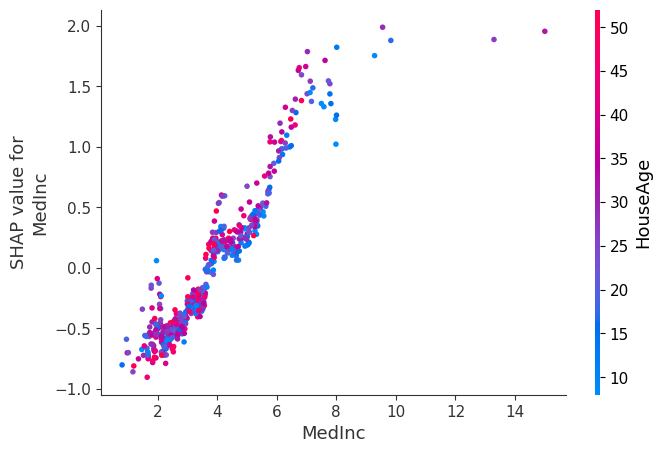

In [6]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("MedInc", shap_values.values, X, interaction_index="HouseAge")

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high MedInc (median income in block group) increases the predicted home price.

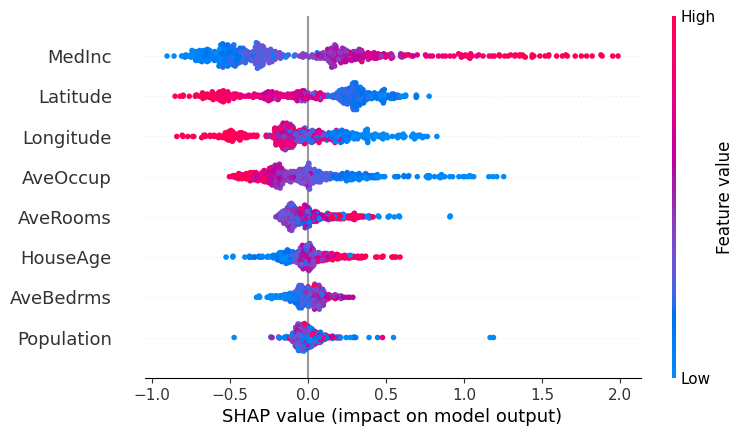

In [7]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

You can also use SHAP values to analyze importance of categorical features.

In [8]:
import catboost.datasets

train_df, test_df = catboost.datasets.amazon()
y = train_df.ACTION
X = train_df.drop("ACTION", axis=1)
cat_features = list(range(0, X.shape[1]))

In [9]:
model = CatBoostClassifier(iterations=300, learning_rate=0.1, random_seed=12)
model.fit(X, y, cat_features=cat_features, verbose=False, plot=False)

In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X, y)

Here is the visualization of feature importances for one positive and one negative example.
Note that binary classification output is a value not in range `[0,1]`. You need to calculate a sigmoid function value, to calculate final probabilities.

In [11]:
test_objects = [X.iloc[0:1], X.iloc[91:92]]

for obj in test_objects:
    print("Probability of class 1 = {:.4f}".format(model.predict_proba(obj)[0][1]))
    print(
        "Formula raw prediction = {:.4f}".format(
            model.predict(obj, prediction_type="RawFormulaVal")[0]
        )
    )
    print("\n")

Probability of class 1 = 0.9970
Formula raw prediction = 5.8079


Probability of class 1 = 0.0299
Formula raw prediction = -3.4808



In [12]:
shap.plots.force(shap_values[0, ...])

In [13]:
shap.plots.force(shap_values[91, ...])

In the beeswarm plot below, you can see that absolute values of the features don't matter, because it's hashes. But it is clear from the plot what is the effect of different features.

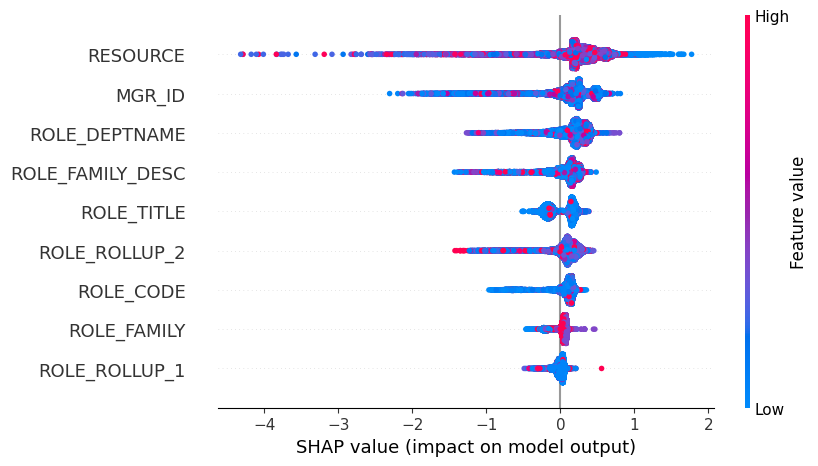

In [14]:
shap.plots.beeswarm(shap_values)

You can calculate SHAP values for multiclass.

In [15]:
model = CatBoostClassifier(
    loss_function="MultiClass", iterations=300, learning_rate=0.1, random_seed=123
)
model.fit(X, y, cat_features=cat_features, verbose=False, plot=False)

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X, y)

Summary plot of SHAP values for formula raw predictions for class 0.

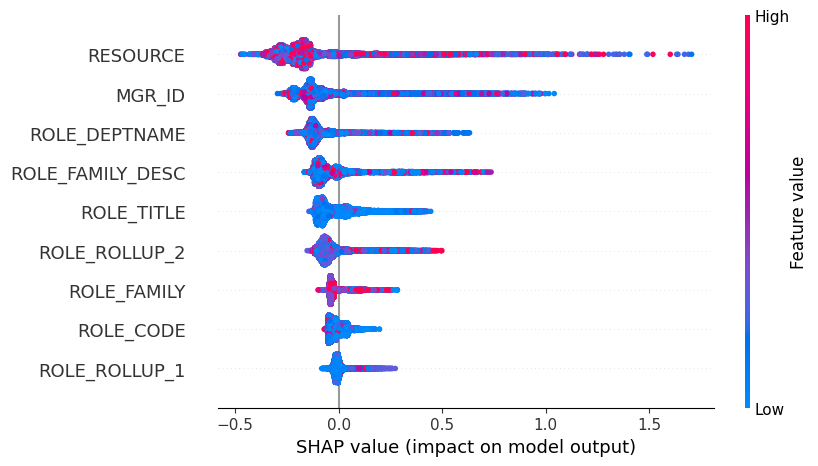

In [17]:
shap.plots.beeswarm(shap_values[..., 0])

And force plot for class 1.

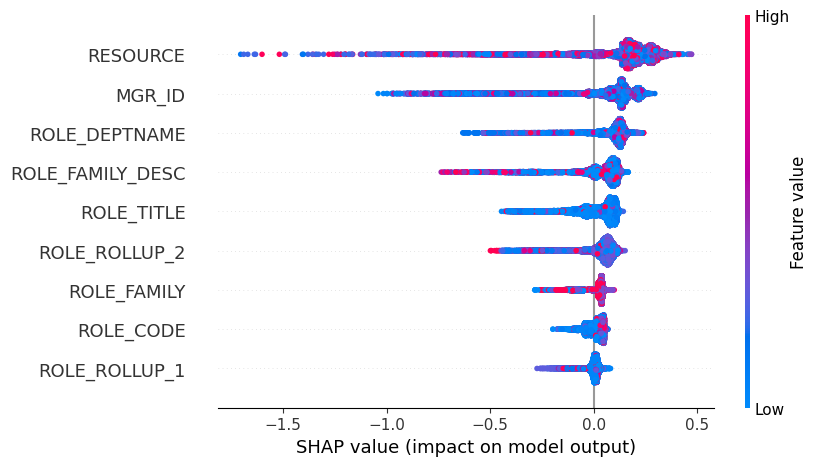

In [18]:
shap.plots.beeswarm(shap_values[..., 1])